### Longitudinal matching in the CPS

Brian Dew, @bd_econ<br>
Updated: April 22, 2018

-----

Small conceptual example: match records across two years first by ID and then by sex, race, and age. Select the subset of people who were not in the labor force due to disability or illness in year one but are employed in year two.


##### Resources:
http://www.nber.org/papers/t0247.pdf<br>
http://trim3.urban.org/documentation/input/concepts%20and%20procedures/CPSMatchingSurveys.php <br>
https://www.nytimes.com/2018/03/15/upshot/will-employment-keep-growing-disabled-workers-offer-a-clue.html <br>
https://github.com/TomAugspurger/pycps/blob/master/pycps/merge.py

In [17]:
import pandas as pd
import numpy as np

### Matching observations one year apart

This section attempts to replicate the chart in the Upshot NYT piece by Ernie Tedeschi on flows from disability to work.

In [18]:
# Turn dates into tuple with year and month for each
def month_year_iter( start_month, start_year, end_month, end_year ):
    ym_start= 12*start_year + start_month - 1
    ym_end= 12*end_year + end_month - 1
    for ym in range( ym_start, ym_end ):
        y, m = divmod( ym, 12 )
        yield y, m+1

# Caclulate the share of NILF due to disability with a job 12 months later
def disill_to_work(year1, month):
    """Calculated share of disabled with job one year later"""
    # Read two years of CPS data into pandas dataframes
    df1 = pd.read_feather(f'data/cps_{year1}.ft', nthreads=3)
    df2 = pd.read_feather(f'data/cps_{year1 + 1}.ft', nthreads=3)
    # Keep only selected month from each
    df1 = df1[(df1['HRMONTH'] == month) & (df1['HRMIS'].isin([1, 2, 3, 4]))]
    df2 = df2[(df2['HRMONTH'] == month) & (df2['HRMIS'].isin([5, 6, 7, 8]))]

    # Combine the two
    df = df1.append(df2)
    df = df[df['PRTAGE'].between(25, 54)]
    
    # Create a unique ID based
    df['UniqueID'] = (df['HRHHID'].astype(str) + 
                        df['HRHHID2'].astype(str) + 
                        df['PULINENO'].astype(str))

    # Identify disabled or ill as variable
    df['disill'] = np.where(((df['PRWNTJOB']==2) & 
                            ((df['PEMLR']==6) | 
                             (df['PENLFACT'].isin([1, 2])))), 1, 0)
    
    if 'HRYEAR' in df.keys():
        df['HRYEAR4'] = df['HRYEAR'] + 1900
    
    # Groups based on month and month in survey
    g1 = df[(df['HRMIS'] == 1) & (df['HRYEAR4'] == year1)]
    g5 = df[(df['HRMIS'] == 5) & (df['HRYEAR4'] == (year1 + 1))]
    g2 = df[(df['HRMIS'] == 2) & (df['HRYEAR4'] == year1)]
    g6 = df[(df['HRMIS'] == 6) & (df['HRYEAR4'] == (year1 + 1))]
    g3 = df[(df['HRMIS'] == 3) & (df['HRYEAR4'] == year1)]
    g7 = df[(df['HRMIS'] == 7) & (df['HRYEAR4'] == (year1 + 1))]
    g4 = df[(df['HRMIS'] == 4) & (df['HRYEAR4'] == year1)]
    g8 = df[(df['HRMIS'] == 8) & (df['HRYEAR4'] == (year1 + 1))]
    
    # So-called naive match based on id and month in sample
    naive = (pd.merge(g1, g5, on='UniqueID', how='inner').append(
             pd.merge(g2, g6, on='UniqueID', how='inner')).append(
             pd.merge(g3, g7, on='UniqueID', how='inner')).append(
             pd.merge(g4, g8, on='UniqueID', how='inner')))
    
    # Keeping the observations with the same sex and race
    # Age should be no more than one year more than prev. mo.
    data = naive[(naive['PESEX_x'] == naive['PESEX_y']) &
                 (naive['PRDTRACE_x'] == naive['PRDTRACE_y']) &
                 (naive['PRTAGE_x'] <= naive['PRTAGE_y'] + 2) &
                 (naive['PRTAGE_y'] >= naive['PRTAGE_x'])]
    
    # This part will require careful thought, but here's a start
    outflow = data[(data['disill_x'] > data['disill_y']) & (data['PEMLR_y'].isin([1,2]))]['PWSSWGT_x'].sum()

    total = data[data['disill_x'] == 1]['PWSSWGT_x'].sum()

    share = outflow/total * 100
    return share

C:\Users\BDew\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in longlong_scalars


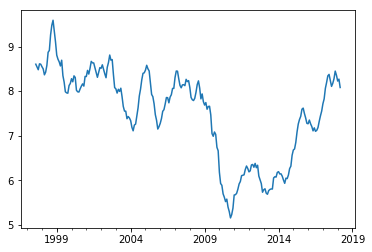

In [19]:
%matplotlib inline
# Plot results
dft = pd.Series()
for year, month in list(month_year_iter(1, 1994, 4, 2017)):
    sh = disill_to_work(year, month)
    dft.loc[pd.to_datetime(f'{year + 1}-{month}-01')] = sh
    
dft.rolling(12).mean().plot()

In [4]:
# Read 2018 CPS data into pandas dataframe
df = pd.read_feather('data/cps_2018.ft', nthreads=3)

# Keep only two months
df = df[df['HRMONTH'].isin([1, 2])]

In [5]:
# Create a unique ID based
df['UniqueID'] = (df['HRHHID'].astype(str) + 
                  df['HRHHID2'].astype(str) + 
                  df['PULINENO'].astype(str))

# Identify disabled or ill as variable
df['disill'] = np.where(((df['PRWNTJOB']==2) & 
                        ((df['PEMLR']==6) | 
                         (df['PENLFACT'].isin([1, 2])))), 1, 0)

In [6]:
# Groups based on month and month in survey
g1mo1 = df[(df['HRMIS'].isin([1, 5])) & (df['HRMONTH'] == 1)]
g2mo1 = df[(df['HRMIS'].isin([2, 6])) & (df['HRMONTH'] == 1)]
g2mo2 = df[(df['HRMIS'].isin([2, 6])) & (df['HRMONTH'] == 2)]
g3mo1 = df[(df['HRMIS'].isin([3, 7])) & (df['HRMONTH'] == 1)]
g3mo2 = df[(df['HRMIS'].isin([3, 7])) & (df['HRMONTH'] == 2)]
g4mo2 = df[(df['HRMIS'].isin([4, 8])) & (df['HRMONTH'] == 2)]

In [7]:
# So-called naive match based on id and month in sample
naive = (pd.merge(g1mo1, g2mo2, on='UniqueID', how='inner').append(
         pd.merge(g2mo1, g3mo2, on='UniqueID', how='inner')).append(
         pd.merge(g2mo1, g3mo2, on='UniqueID', how='inner')).append(
         pd.merge(g3mo1, g4mo2, on='UniqueID', how='inner')))

In [8]:
# Keeping the observations with the same sex and race
# Age should be no more than one year more than prev. mo.
data = naive[(naive['PESEX_x'] == naive['PESEX_y']) &
             (naive['PRDTRACE_x'] == naive['PRDTRACE_y']) &
             (naive['PRTAGE_x'] <= naive['PRTAGE_y'] + 1) &
             (naive['PRTAGE_y'] >= naive['PRTAGE_x'])]

In [9]:
# This part will require careful thought, but here's a start
data[data['disill_x'] > data['disill_y']]

,HRHHID_x,HRMONTH_x,HRYEAR4_x,HRMIS_x,HRHHID2_x,GESTFIPS_x,GTMETSTA_x,PRTAGE_x,PESEX_x,PEEDUCA_x,...,PRERNWA_y,PEERNLAB_y,PENLFRET_y,PENLFACT_y,PWORWGT_y,PWSSWGT_y,PRCHLD_y,PWCMPWGT_y,WBHAO_y,disill_y
22,31817006100046,1,2018,5,6011,1,1,59,1,43,...,-1,-1,-1,-1,0,20375582,0,21020585,1,0
314,59071076004611,1,2018,5,6111,1,2,42,2,40,...,-1,-1,-1,-1,0,12630492,3,12836390,1,0
569,309015962210563,1,2018,1,8011,2,1,52,2,44,...,-1,-1,-1,-1,0,5245895,0,5353668,1,0
1085,840866110903607,1,2018,5,6011,4,1,61,1,39,...,-1,-1,-1,-1,0,28213557,0,28456081,1,0
1361,28025469002021,1,2018,1,8011,5,2,33,1,41,...,-1,-1,-1,-1,0,11587374,0,11290149,1,0
1383,148690050029820,1,2018,1,8011,5,2,32,1,43,...,-1,-1,-1,4,0,11587374,3,11508348,1,0
1521,621751002200393,1,2018,1,8111,5,1,56,2,43,...,-1,-1,-1,-1,0,13662704,0,13846572,1,0
1546,610663300698,1,2018,1,8011,6,1,52,1,41,...,-1,-1,2,4,0,37348022,0,37257370,1,0
1705,27390419014675,1,2018,5,6011,6,1,51,1,40,...,-1,-1,2,6,0,35109721,0,35024501,1,0
1753,61365009700984,1,2018,1,8011,6,1,76,2,42,...,-1,-1,-1,-1,0,31106647,0,31429501,1,0


### Small example of matching across years

In [10]:
# Read two years of CPS data into pandas dataframes
df1 = pd.read_feather('data/cps_2016.ft', nthreads=3)
df2 = pd.read_feather('data/cps_2017.ft', nthreads=3)
# Keep only February from each
df1 = df1[(df1['HRMONTH'] == 2) & (df1['HRMIS'].isin([1, 2, 3, 4]))]
df2 = df2[(df2['HRMONTH'] == 2) & (df2['HRMIS'].isin([5, 6, 7, 8]))]

# Combine the two
df = df1.append(df2)
df = df[df['PRTAGE'].between(25, 54)]

In [11]:
# Create a unique ID based
df['UniqueID'] = (df['HRHHID'].astype(str) + 
                  df['HRHHID2'].astype(str) + 
                  df['PULINENO'].astype(str))

# Identify disabled or ill as variable
df['disill'] = np.where(((df['PRWNTJOB']==2) & 
                        ((df['PEMLR']==6) | 
                         (df['PENLFACT'].isin([1, 2])))), 1, 0)

In [12]:
# Groups based on month and month in survey
g1 = df[(df['HRMIS'] == 1) & (df['HRYEAR4'] == 2017)]
g5 = df[(df['HRMIS'] == 5) & (df['HRYEAR4'] == 2018)]
g2 = df[(df['HRMIS'] == 2) & (df['HRYEAR4'] == 2017)]
g6 = df[(df['HRMIS'] == 6) & (df['HRYEAR4'] == 2018)]
g3 = df[(df['HRMIS'] == 3) & (df['HRYEAR4'] == 2017)]
g7 = df[(df['HRMIS'] == 7) & (df['HRYEAR4'] == 2018)]
g4 = df[(df['HRMIS'] == 4) & (df['HRYEAR4'] == 2017)]
g8 = df[(df['HRMIS'] == 8) & (df['HRYEAR4'] == 2018)]

In [13]:
# So-called naive match based on id and month in sample
naive = (pd.merge(g1, g5, on='UniqueID', how='inner').append(
         pd.merge(g2, g6, on='UniqueID', how='inner')).append(
         pd.merge(g3, g7, on='UniqueID', how='inner')).append(
         pd.merge(g4, g8, on='UniqueID', how='inner')))

In [14]:
# Keeping the observations with the same sex and race
# Age should be no more than one year more than prev. mo.
data = naive[(naive['PESEX_x'] == naive['PESEX_y']) &
             (naive['PRDTRACE_x'] == naive['PRDTRACE_y']) &
             (naive['PRTAGE_x'] <= naive['PRTAGE_y'] + 1) &
             (naive['PRTAGE_y'] >= naive['PRTAGE_x'])]

In [15]:
# This part will require careful thought, but here's a start
outflow = data[(data['disill_x'] > data['disill_y']) & (data['PEMLR_y'].isin([1,2]))]['PWSSWGT_y'].sum()

total = data[data['disill_x'] == 1]['PWSSWGT_y'].sum()

share = outflow/total * 100
print(month)
print(share)

3
nan


C:\Users\BDew\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  


In [16]:
total = data[data['disill_x'] == 1]['PWSSWGT_y'].sum()